### In this notebook we will perform EDA on the data , preprocess it and finally build a few models to predict the stock prices

In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_csv(r"/kaggle/input/snp500-dataset/snp500_history.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1,1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
2,1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
3,1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
4,1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


In [27]:
df['Date'] = df['Date'].apply(lambda value :(value.split( )[0]))
df['Date']= pd.to_datetime(df['Date'])

In [28]:
# Univariate Analysis

In [29]:
start_date = '1990-01-01'
end_date = '2023-12-31'
date_range_mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
data = df[date_range_mask].copy()

In [30]:
data = data[['Date' , 'Open']]

del df

In [31]:
data.set_index('Date', inplace = True)

## EDA

In [33]:
data.head()

,Open
Date,
1990-01-02,353.399994
1990-01-03,359.690002
1990-01-04,358.760010
1990-01-05,355.670013
1990-01-08,352.200012


In [34]:
data.describe()

,Open
count,8420.000000
mean,1534.280623
std,1031.140049
min,295.450012
25%,886.990005
50%,1258.979980
75%,1992.337494
max,4804.509766


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8420 entries, 1990-01-02 to 2023-06-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    8420 non-null   float64
dtypes: float64(1)
memory usage: 131.6 KB


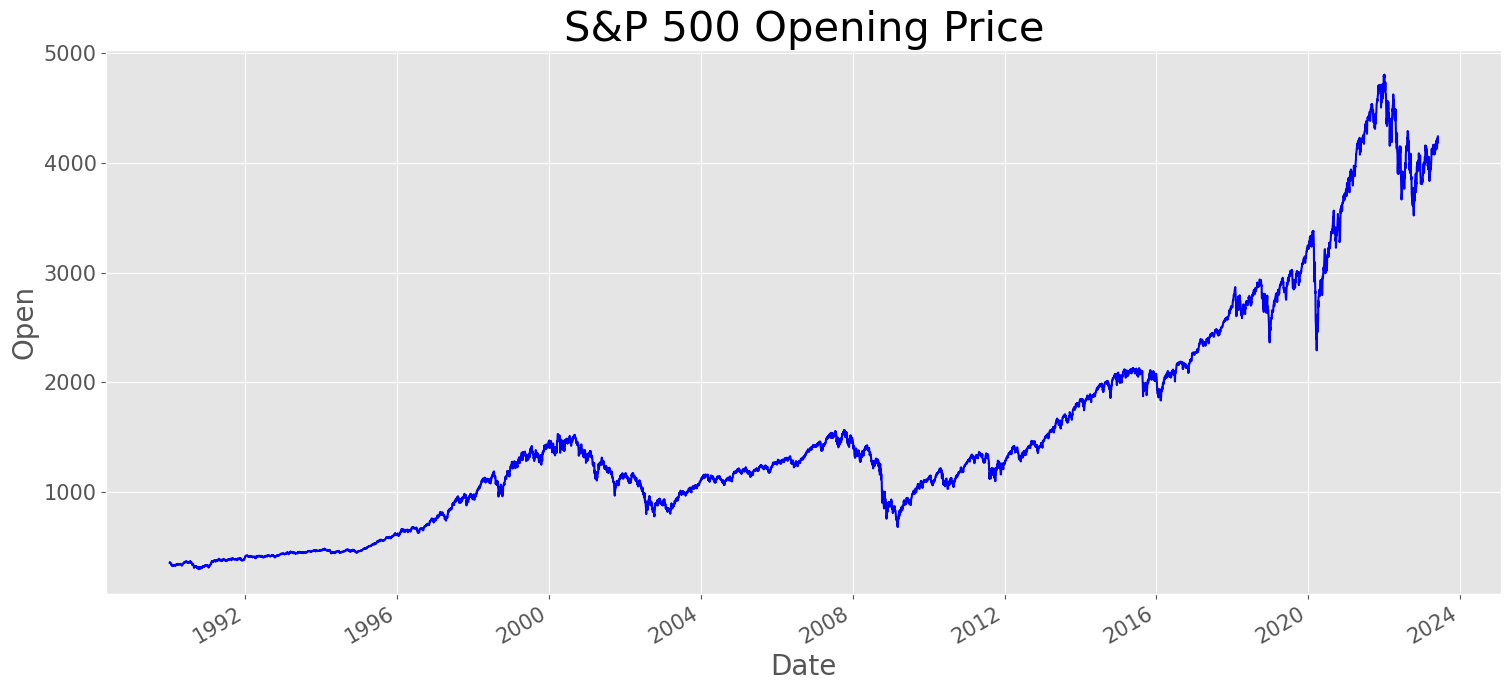

In [36]:
plt.style.use('ggplot')
plt.figure(figsize = (18,8))
plt.grid(True)
plt.xlabel('Dates' , fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Open' , fontsize = 20)
data['Open'].plot(color = 'blue')
plt.yticks(fontsize = 15)
plt.title('S&P 500 Opening Price' , fontsize = 30)
plt.show()


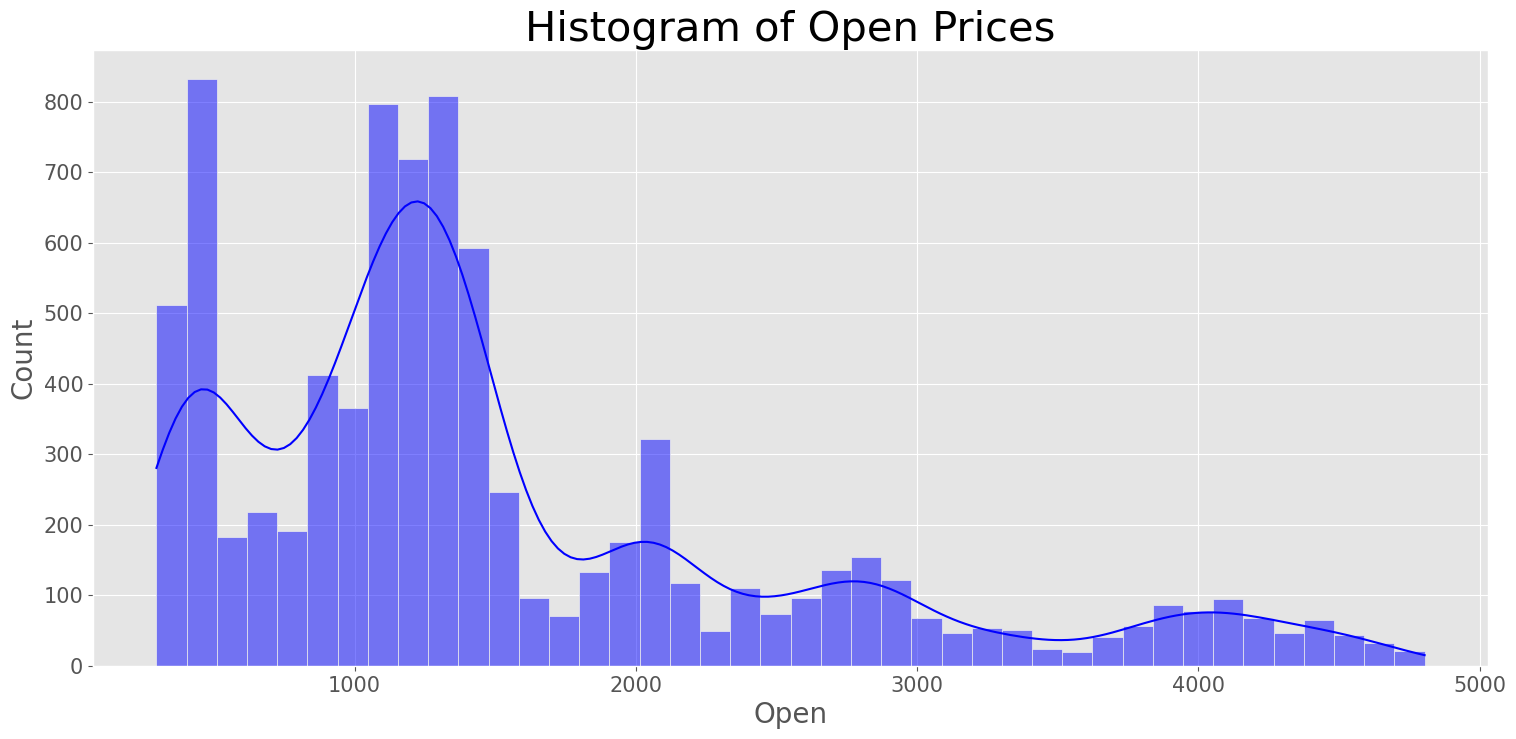

In [37]:
plt.figure(figsize=(18, 8)) 
sns.histplot(data['Open'], kde=True, color='blue')
plt.xlabel('Open', fontsize=20)
plt.xticks(fontsize = 15)
plt.ylabel('Count', fontsize=20)
plt.yticks(fontsize  = 15)
plt.title('Histogram of Open Prices', fontsize=30)
plt.show()


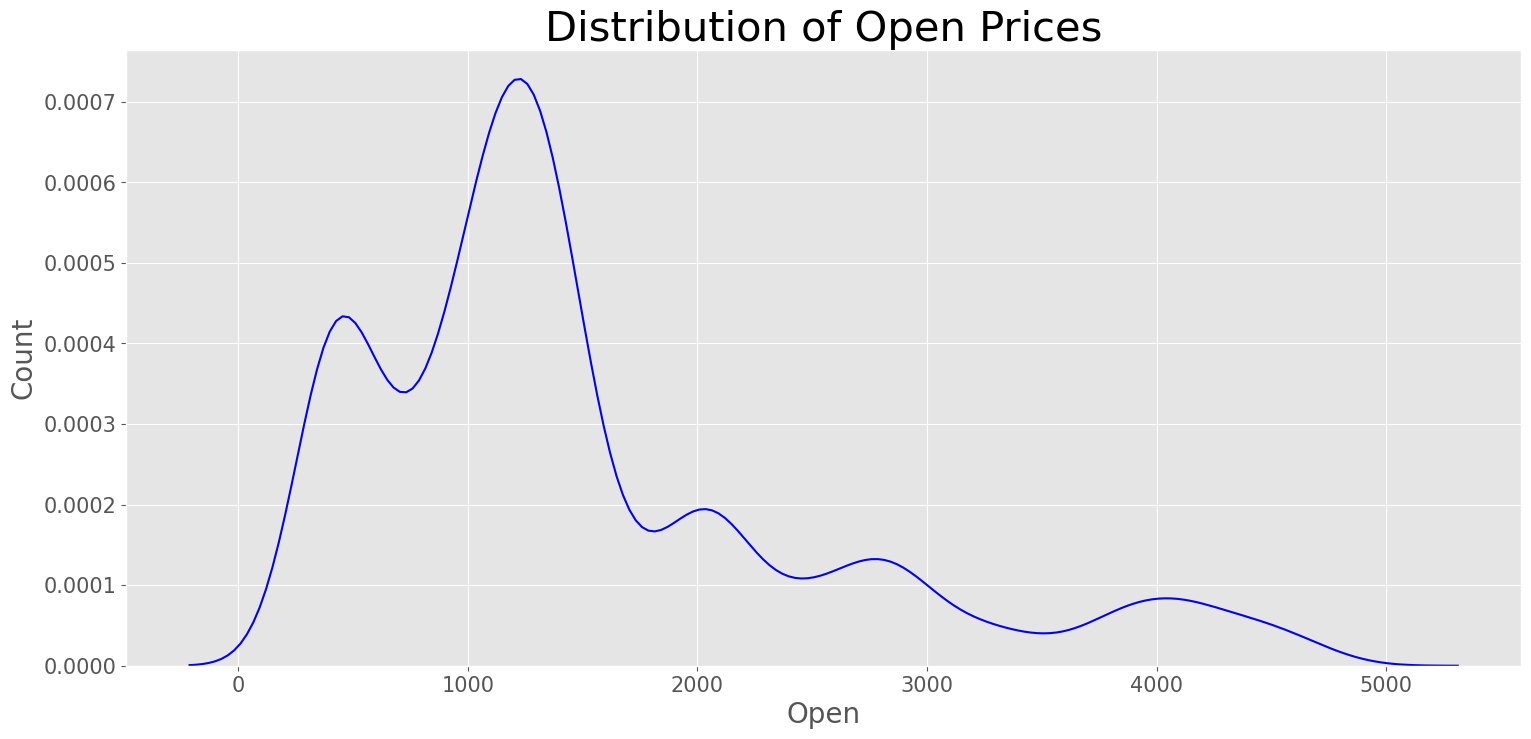

In [38]:
#sns.distplot(data ['Open'], hist = False)
plt.figure(figsize= (18, 8))
sns.kdeplot(data['Open'], color= 'blue')
plt.xlabel('Open', fontsize=20)
plt.xticks(fontsize = 15)
plt.ylabel('Count', fontsize=20)
plt.yticks(fontsize  = 15)
plt.title('Distribution of Open Prices', fontsize=30)
plt.show()

In [39]:
rol_mean= data['Open'].rolling(60).mean()
rol_std = data['Open'].rolling(60).std()

### ADF Test

### <u>Hypothesis for ADFT:</u>
#### NULL Hypothesis (H⁰) assumes that the series has a trend or is non stationary

#### ALT Hypothesis(H1) assumes that the series is stationary
   

In [40]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(data['Open'])

In [41]:
adft

(1.1175220392180747,
 0.995363426326394,
 36,
 8383,
 {'1%': -3.4311303057993676,
  '5%': -2.8618848414218716,
  '10%': -2.566953554226757},
 73428.2771037471)

In [42]:
pd.Series(adft[0:4] , index = ['test stats' , 'p-value' , 'lag' , 'data points'])

test stats        1.117522
p-value           0.995363
lag              36.000000
data points    8383.000000
dtype: float64

In [43]:
# Functiom to test stationarity of data:

def test_stationarity(timeseries):
    
    rol_mean = timeseries.rolling(365).mean() 
    rol_std = timeseries.rolling(365).std() 
   
    plt.figure(figsize = (18,8))
    plt.grid('both')
    plt.plot(timeseries, color='blue',label='Original', linewidth = 3)
    plt.plot(rol_mean, color='red', label='Rolling Mean',linewidth = 3)
    plt.plot(rol_std, color='black', label = 'Rolling Std',linewidth = 4)
    plt.legend(loc='best', fontsize = 20, shadow=True,facecolor='lightyellow',edgecolor = 'blue')
    plt.title('Rolling Mean and Standard Deviation', fontsize = 25)
    plt.xlabel('Date', fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.ylabel('Open Price' , fontsize = 20)
    plt.yticks(fontsize = 15)
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    


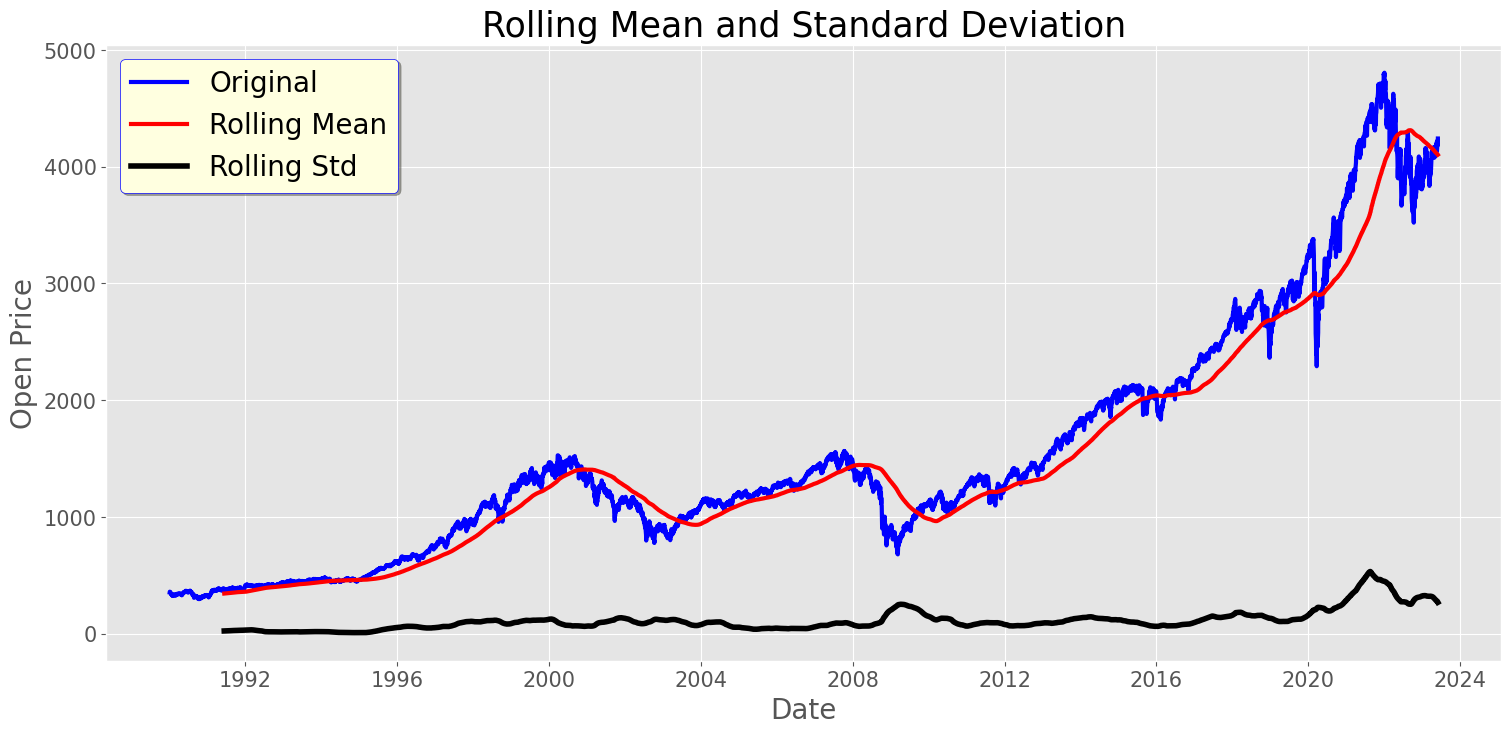

Results of dickey fuller test
Test Statistics                   1.117522
p-value                           0.995363
No. of lags used                 36.000000
Number of observations used    8383.000000
critical value (1%)              -3.431130
critical value (5%)              -2.861885
critical value (10%)             -2.566954
dtype: float64


In [44]:
test_stationarity(data['Open'])

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data[['Open']], model = 'additive', period = 365)

<Figure size 1800x800 with 0 Axes>

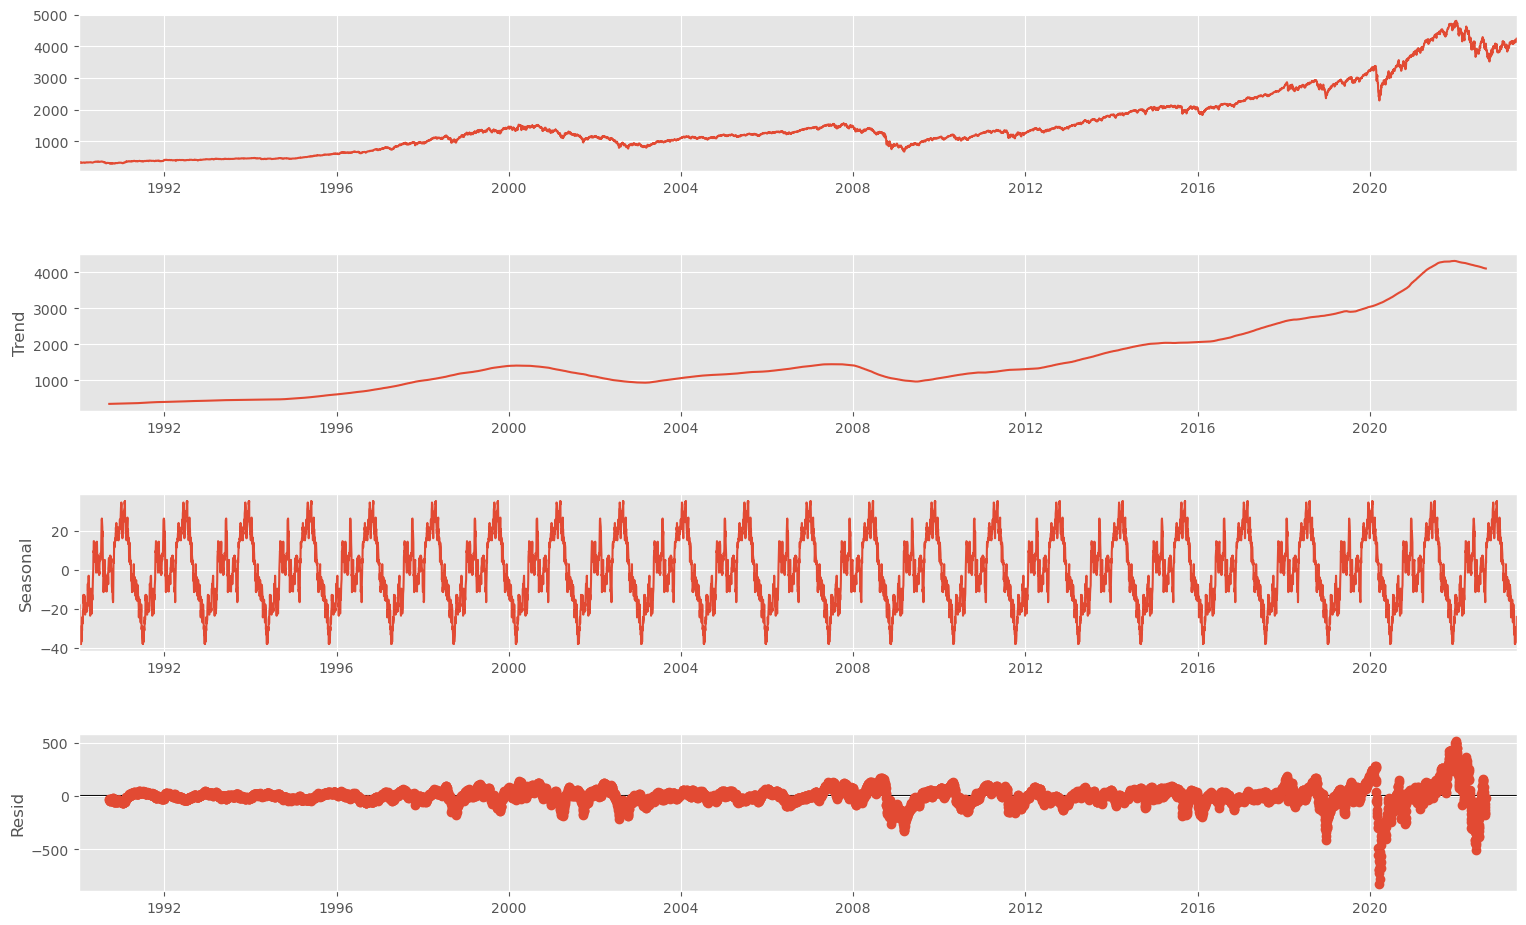

In [46]:
fig = plt.figure(figsize = (18, 8))
fig = result.plot()
fig.set_size_inches(17, 10)

### Multiplicative Decomposition

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data[['Open']], model = 'multiplicative', period = 365)

<Figure size 1800x800 with 0 Axes>

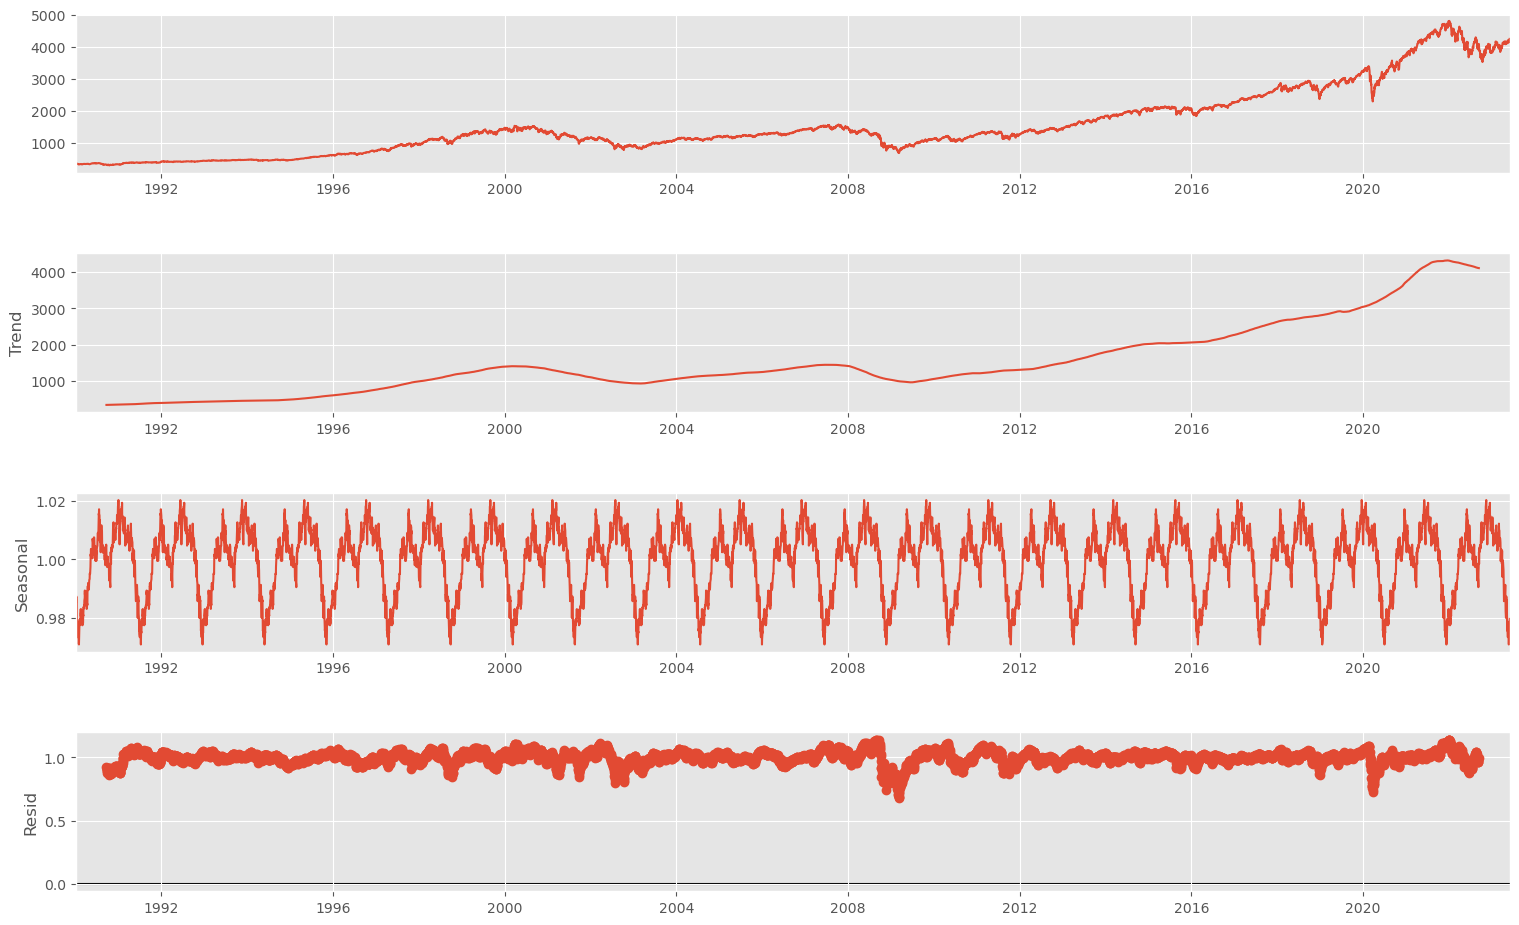

In [48]:
fig = plt.figure(figsize = (18, 8))
fig = result.plot()
fig.set_size_inches(17, 10)

<Axes: >

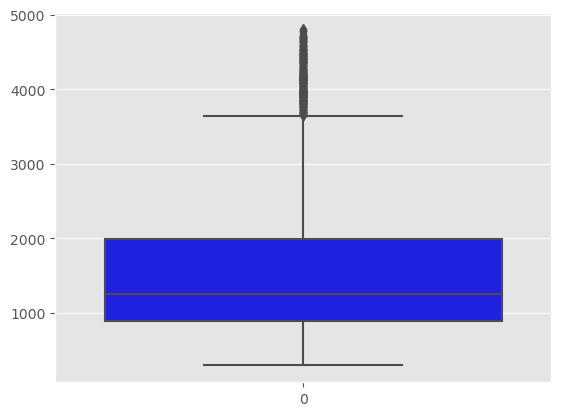

In [49]:
sns.boxplot(data['Open'], color = 'blue')

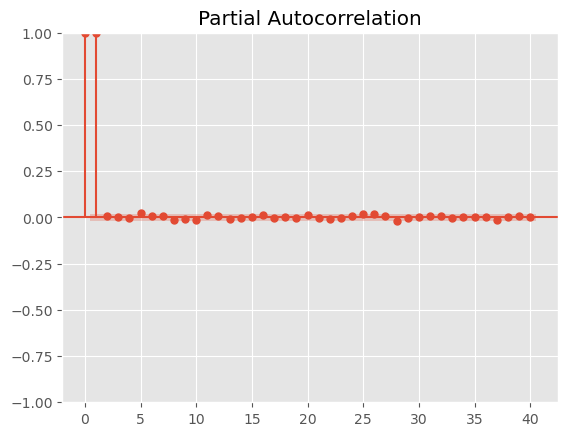

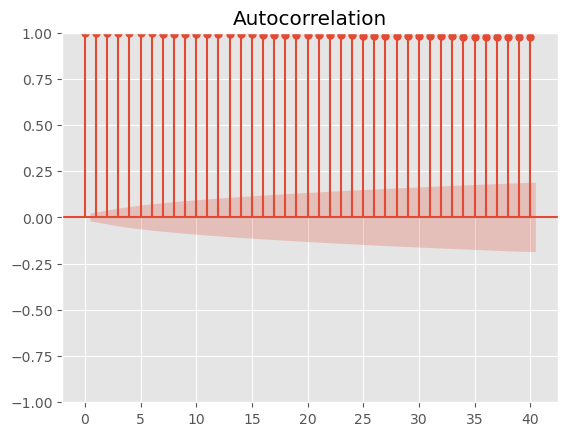

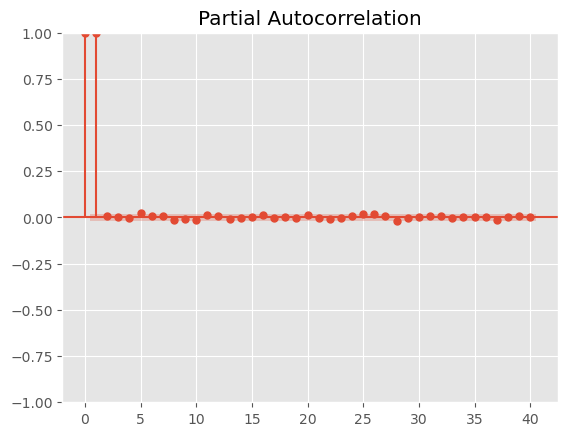

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Open'])
plot_pacf(data['Open'])

### Train Test Split

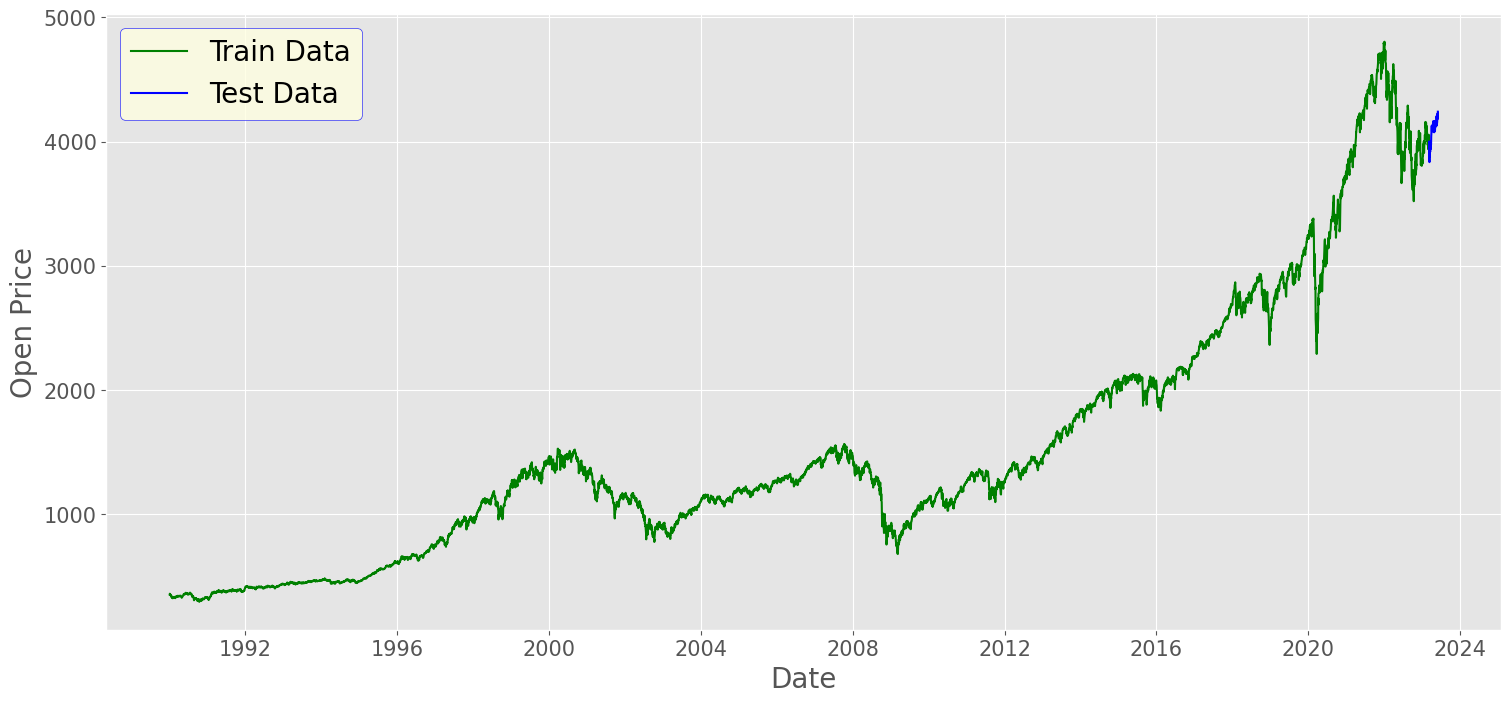

In [54]:
train_data = data['Open'][0 : -60] 
# Keeping the last 60 rows for test 
test_data = data['Open'][-60:]
plt.figure(figsize = (18, 8))
plt.grid(True)
plt.xlabel('Date', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Open Price' , fontsize = 20)
plt.yticks(fontsize = 15 )
plt.plot(train_data , 'green' , label = 'Train Data' )
plt.plot(test_data, 'blue' , label = 'Test Data')
plt.legend(fontsize = 20 , facecolor = 'lightyellow', edgecolor = 'blue' )

### Model Building

In [55]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [56]:
history = [x for x in train_data]

In [57]:
len(history)

8360

In [65]:
def train_arima_model(X, y , arima_order):
    history = [x for x in X]
    predictions = list()
    for t in range(len(y)):
        model = ARIMA(history, order= arima_order)
        model_fit = model.fit()
        y_pred = model_fit.forecast()[0]
        predictions.append(y_pred)
        history.append(y[t])
        
        
    rmse = np.sqrt(mean_squared_error(y , predictions))
    return rmse
        

In [66]:
def evaluate_model(dataset, test, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_config = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = train_arima_model(dataset, test, order)
                    if rmse < best_score:
                        best_score, best_config = rmse,order
                    print('ARIMA %s RMSE = %.3f' %(order, rmse))   
                        
                except:
                    continue
    print('Best ARIMA%s RMSE = %.3f' %(best_config, best_score))                  
    

In [67]:
p_values = range(0,3)
d_values = range(0,3)
q_values = range(0,3)
evaluate_model(train_data, test_data , p_values, d_values, q_values)

ARIMA (0, 0, 0) RMSE = 2562.033
ARIMA (0, 0, 1) RMSE = 1291.305
ARIMA (0, 0, 2) RMSE = 731.695
ARIMA (0, 1, 0) RMSE = 35.089
ARIMA (0, 1, 1) RMSE = 35.172
ARIMA (0, 1, 2) RMSE = 35.137
ARIMA (0, 2, 0) RMSE = 51.177
ARIMA (0, 2, 1) RMSE = 35.027
ARIMA (0, 2, 2) RMSE = 35.112
ARIMA (1, 0, 0) RMSE = 35.120
ARIMA (1, 0, 1) RMSE = 35.203
ARIMA (1, 0, 2) RMSE = 35.159
ARIMA (1, 1, 0) RMSE = 35.172
ARIMA (1, 1, 1) RMSE = 35.165
ARIMA (1, 1, 2) RMSE = 35.078
ARIMA (1, 2, 0) RMSE = 44.833
ARIMA (1, 2, 1) RMSE = 35.110
ARIMA (1, 2, 2) RMSE = 34.979
ARIMA (2, 0, 0) RMSE = 35.200
ARIMA (2, 0, 1) RMSE = 35.061
ARIMA (2, 0, 2) RMSE = 35.153
ARIMA (2, 1, 0) RMSE = 35.141
ARIMA (2, 1, 1) RMSE = 35.100
ARIMA (2, 1, 2) RMSE = 35.067
ARIMA (2, 2, 0) RMSE = 40.390
ARIMA (2, 2, 1) RMSE = 35.080
ARIMA (2, 2, 2) RMSE = 35.076
Best ARIMA(1, 2, 2) RMSE = 34.979


In [75]:
history = [x for x in train_data]
predictions = list()
conf_list = list()
for t in range(len(test_data)):
    model = ARIMA(history,order=(1,2,2))
    model_fit = model.fit()
    fc = model_fit.forecast(alpha = 0.05)
    predictions.append(fc)
    history.append(test_data[t])
print('RMSE of ARIMA Model:', np.sqrt(mean_squared_error(test_data, predictions)))

RMSE of ARIMA Model: 34.97870108256449


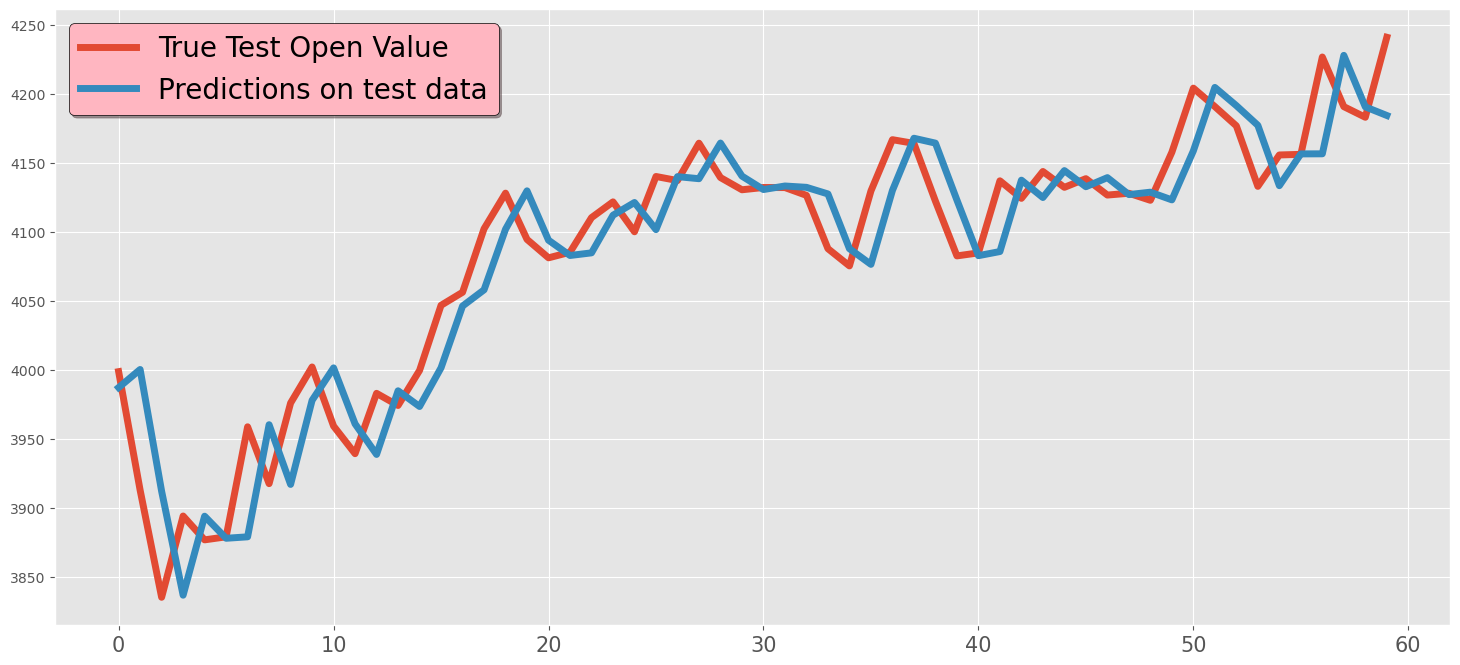

In [76]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_data)),test_data, label = 'True Test Open Value', linewidth = 5)
plt.plot(range(len(predictions)), predictions, label = 'Predictions on test data', linewidth = 5)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

In [70]:
fc_series = pd.Series(predictions, index = test_data.index)

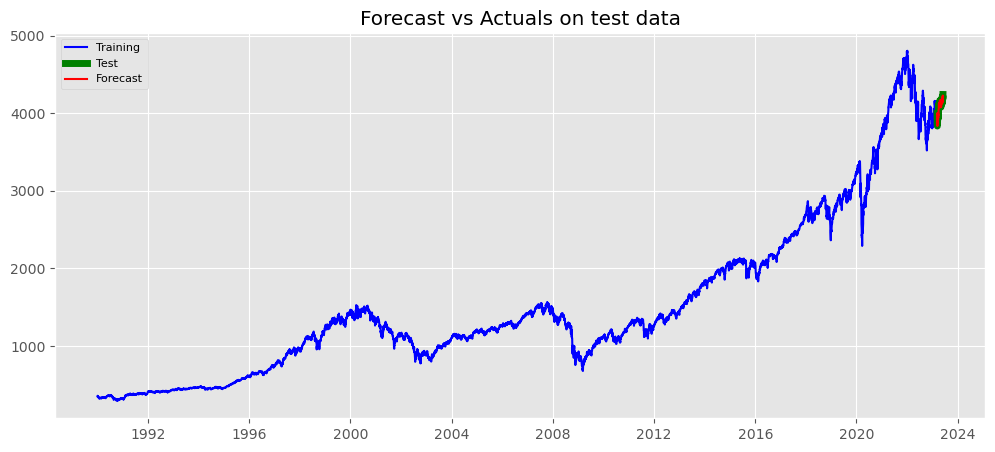

In [85]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training', color = 'blue')
plt.plot(test_data, label='Test', color = 'green', linewidth = 5)
plt.plot(fc_series, label='Forecast', color = 'red')
plt.title('Forecast vs Actuals on test data')
plt.legend(loc='upper left', fontsize=8)
plt.show()

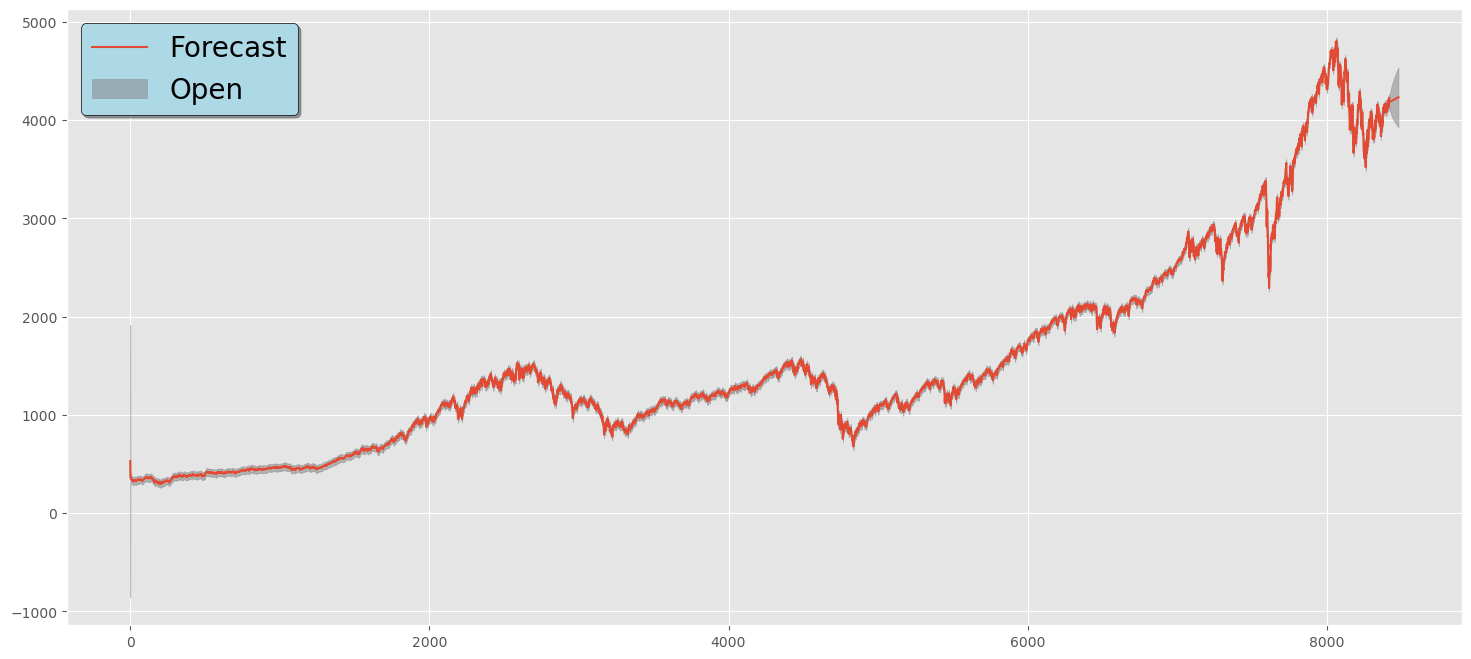

In [72]:
from statsmodels.graphics.tsaplots import plot_predict
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(111)
plot_predict(result = model_fit,start = 1, end = len(data) + 60, ax = ax1)
plt.grid("both")
plt.legend(['Forecast','Open','95% confidence interval'],fontsize = 20, shadow = True,facecolor = 'lightblue',edgecolor = 'k')
plt.show()

### SARIMAX Model

In [80]:
import warnings
warnings.filterwarnings('ignore')
history = [x for x in train_data]
predictions = list()
conf_list = list()
for t in range(len(test_data)):
    model = sm.tsa.statespace.SARIMAX(history, order = (1,2,2), seasonal_order = (1,1,1,3))
    model_fit = model.fit()
    fc = model_fit.forecast()
    predictions.append(fc)
    history.append(test_data[t])
print('RMSE of SARIMA Model:', np.sqrt(mean_squared_error(test_data, predictions)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66133D+00    |proj g|=  9.17083D-02


 This problem is unconstrained.



At iterate    5    f=  4.53563D+00    |proj g|=  1.94836D-02

At iterate   10    f=  4.37229D+00    |proj g|=  4.96464D-04

At iterate   15    f=  4.37224D+00    |proj g|=  2.72619D-03

At iterate   20    f=  4.37208D+00    |proj g|=  5.70374D-03

At iterate   25    f=  4.37206D+00    |proj g|=  6.48195D-04

At iterate   30    f=  4.37205D+00    |proj g|=  1.32295D-03

At iterate   35    f=  4.37205D+00    |proj g|=  4.62616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     73      1     0     0   4.151D-04   4.372D+00
  F =   4.3720446322203728     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.53577D+00    |proj g|=  1.94858D-02

At iterate   10    f=  4.37237D+00    |proj g|=  6.52879D-04

At iterate   15    f=  4.37182D+00    |proj g|=  4.84682D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     34      1     0     0   4.847D-03   4.372D+00
  F =   4.3718182722932717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66212D+00    |proj g|=  9.18553D-02

At iterate    5    f=  4.53456D+00    |proj g|=  1.94398D-02

At iterate   10    f=  4.37320D+00    |proj g|=  2.39045D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     20      1     0     0   2.390D-03   4.373D+00
  F =   4.3732048215874295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  4.53893D+00    |proj g|=  1.94456D-02

At iterate   10    f=  4.37560D+00    |proj g|=  2.94759D-02

At iterate   15    f=  4.37427D+00    |proj g|=  7.14157D-03

At iterate   20    f=  4.37408D+00    |proj g|=  4.47064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     35      1     0     0   2.232D-04   4.374D+00
  F =   4.3740557950491104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53738D+00    |proj g|=  1.94223D-02

At iterate   10    f=  4.37512D+00    |proj g|=  4.91836D-03

At iterate   15    f=  4.37484D+00    |proj g|=  3.44151D-03

At iterate   20    f=  4.37461D+00    |proj g|=  2.29885D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     44      1     0     0   8.368D-05   4.375D+00
  F =   4.3746116413623826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53668D+00    |proj g|=  1.94129D-02

At iterate   10    f=  4.37468D+00    |proj g|=  2.80594D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     26      1     0     0   2.799D-03   4.375D+00
  F =   4.3746758284692984     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66345D+00    |proj g|=  9.17793D-02


 This problem is unconstrained.



At iterate    5    f=  4.53614D+00    |proj g|=  1.94073D-02

At iterate   10    f=  4.37537D+00    |proj g|=  3.76216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     17      1     0     0   1.025D-03   4.375D+00
  F =   4.3745181306185295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66342D+00    |proj g|=  9.12825D-02


 This problem is unconstrained.



At iterate    5    f=  4.53731D+00    |proj g|=  1.93921D-02

At iterate   10    f=  4.37563D+00    |proj g|=  1.48366D-03

At iterate   15    f=  4.37561D+00    |proj g|=  1.69728D-03

At iterate   20    f=  4.37550D+00    |proj g|=  3.89095D-03

At iterate   25    f=  4.37542D+00    |proj g|=  5.05528D-04

At iterate   30    f=  4.37542D+00    |proj g|=  2.83874D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     53      1     0     0   1.335D-04   4.375D+00
  F =   4.3754236297409506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  4.53631D+00    |proj g|=  1.93711D-02

At iterate   10    f=  4.37599D+00    |proj g|=  1.54980D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     24      1     0     0   5.939D-04   4.376D+00
  F =   4.3756985841420146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66401D+00    |proj g|=  9.16296D-02


 This problem is unconstrained.



At iterate    5    f=  4.53754D+00    |proj g|=  1.93735D-02

At iterate   10    f=  4.37632D+00    |proj g|=  6.15438D-04

At iterate   15    f=  4.37622D+00    |proj g|=  8.53508D-04

At iterate   20    f=  4.37612D+00    |proj g|=  7.88098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     41      1     0     0   6.580D-04   4.376D+00
  F =   4.3761089998790519     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53424D+00    |proj g|=  1.93324D-02

At iterate   10    f=  4.37617D+00    |proj g|=  1.71690D-03

At iterate   15    f=  4.37616D+00    |proj g|=  8.21898D-04

At iterate   20    f=  4.37611D+00    |proj g|=  1.90464D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     38      1     0     0   6.496D-04   4.376D+00
  F =   4.3761056435215080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53743D+00    |proj g|=  1.93631D-02

At iterate   10    f=  4.37652D+00    |proj g|=  4.25356D-04

At iterate   15    f=  4.37637D+00    |proj g|=  2.60706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     38      1     0     0   9.762D-04   4.376D+00
  F =   4.3763691959234814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66431D+00    |proj g|=  9.15424D-02


 This problem is unconstrained.



At iterate    5    f=  4.53920D+00    |proj g|=  1.93804D-02

At iterate   10    f=  4.37688D+00    |proj g|=  2.04015D-03

At iterate   15    f=  4.37681D+00    |proj g|=  1.61045D-03

At iterate   20    f=  4.37665D+00    |proj g|=  2.18231D-03

At iterate   25    f=  4.37661D+00    |proj g|=  2.58094D-03

At iterate   30    f=  4.37648D+00    |proj g|=  3.85199D-03

At iterate   35    f=  4.37626D+00    |proj g|=  2.51209D-03

At iterate   40    f=  4.37616D+00    |proj g|=  7.08722D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  4.37613D+00    |proj g|=  3.59414D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48    101      2     0     0   6.261D-04   4.376D+00
  F =   4.3761287336294359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66419D+00    |proj g|=  9.14311D-02


 This problem is unconstrained.



At iterate    5    f=  4.53986D+00    |proj g|=  1.93806D-02

At iterate   10    f=  4.37760D+00    |proj g|=  2.02312D-03

At iterate   15    f=  4.37692D+00    |proj g|=  1.28020D-03

At iterate   20    f=  4.37684D+00    |proj g|=  6.84575D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     38      1     0     0   3.575D-03   4.377D+00
  F =   4.3768408533728262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66423D+00    |proj g|=  9.14598D-02

At iterate    5    f=  4.53899D+00    |proj g|=  1.93749D-02

At iterate   10    f=  4.37693D+00    |proj g|=  1.48468D-03

At iterate   15    f=  4.37676D+00    |proj g|=  5.16392D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     40      1     0     0   1.009D-03   4.377D+00
  F =   4.3767325056719555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66426D+00    |proj g|=  9.14874D-02


 This problem is unconstrained.



At iterate    5    f=  4.53823D+00    |proj g|=  1.93636D-02

At iterate   10    f=  4.37677D+00    |proj g|=  1.15888D-03

At iterate   15    f=  4.37675D+00    |proj g|=  3.57651D-03

At iterate   20    f=  4.37667D+00    |proj g|=  8.03306D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  4.37666D+00    |proj g|=  1.36450D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     67      2     0     0   8.559D-04   4.377D+00
  F =   4.3766302504341379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66427D+00    |proj g|=  9.15628D-02


 This problem is unconstrained.



At iterate    5    f=  4.53864D+00    |proj g|=  1.93636D-02

At iterate   10    f=  4.37712D+00    |proj g|=  1.24491D-03

At iterate   15    f=  4.37707D+00    |proj g|=  6.09413D-04

At iterate   20    f=  4.37699D+00    |proj g|=  1.74777D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     40      1     0     0   9.876D-04   4.377D+00
  F =   4.3769939675288567     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53887D+00    |proj g|=  1.93669D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  4.37717D+00    |proj g|=  9.33952D-04

At iterate   15    f=  4.37701D+00    |proj g|=  5.66089D-04

At iterate   20    f=  4.37698D+00    |proj g|=  2.98512D-04

At iterate   25    f=  4.37698D+00    |proj g|=  2.96314D-04
  ys=-1.391E-06  -gs= 3.130E-06 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     72      2     1     0   3.041D-04   4.377D+00
  F =   4.3769769851968565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0   

 This problem is unconstrained.



At iterate    5    f=  4.53899D+00    |proj g|=  1.93601D-02

At iterate   10    f=  4.37741D+00    |proj g|=  8.57556D-04

At iterate   15    f=  4.37734D+00    |proj g|=  3.69753D-04

At iterate   20    f=  4.37726D+00    |proj g|=  1.21366D-03

At iterate   25    f=  4.37724D+00    |proj g|=  2.17835D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     40      1     0     0   4.325D-04   4.377D+00
  F =   4.3772336352478218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.53871D+00    |proj g|=  1.93573D-02

At iterate   10    f=  4.37738D+00    |proj g|=  1.01379D-03

At iterate   15    f=  4.37735D+00    |proj g|=  6.36607D-04

At iterate   20    f=  4.37723D+00    |proj g|=  1.23248D-03

At iterate   25    f=  4.37723D+00    |proj g|=  6.79908D-04

At iterate   30    f=  4.37723D+00    |proj g|=  6.38716D-04

At iterate   35    f=  4.37721D+00    |proj g|=  4.38359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     63      1     0     0   2.233D-04   4.377D+00
  F =   4.3772100024439125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.53868D+00    |proj g|=  1.93530D-02

At iterate   10    f=  4.37751D+00    |proj g|=  6.01005D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     25      1     0     0   4.976D-04   4.377D+00
  F =   4.3774433657805929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66459D+00    |proj g|=  9.15854D-02


 This problem is unconstrained.



At iterate    5    f=  4.53873D+00    |proj g|=  1.93546D-02

At iterate   10    f=  4.37743D+00    |proj g|=  1.60653D-03

At iterate   15    f=  4.37739D+00    |proj g|=  1.10422D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     32      1     0     0   9.186D-04   4.377D+00
  F =   4.3772927635959800     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66454D+00    |proj g|=  9.14543D-02


 This problem is unconstrained.



At iterate    5    f=  4.53914D+00    |proj g|=  1.93622D-02

At iterate   10    f=  4.37760D+00    |proj g|=  5.60509D-03

At iterate   15    f=  4.37744D+00    |proj g|=  3.38575D-03

At iterate   20    f=  4.37732D+00    |proj g|=  4.07334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     44      1     0     0   5.136D-03   4.377D+00
  F =   4.3772782889895456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66477D+00    |proj g|=  9.12797D-02


 This problem is unconstrained.



At iterate    5    f=  4.53846D+00    |proj g|=  1.93506D-02

At iterate   10    f=  4.37947D+00    |proj g|=  4.87922D-02

At iterate   15    f=  4.37731D+00    |proj g|=  7.32633D-04

At iterate   20    f=  4.37722D+00    |proj g|=  4.17148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     42      1     0     0   4.171D-03   4.377D+00
  F =   4.3772224795681929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66485D+00    |proj g|=  9.14215D-02

At iterate    5    f=  4.53806D+00    |proj g|=  1.93466D-02

At iterate   10    f=  4.37758D+00    |proj g|=  2.45702D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     19      1     0     0   1.222D-03   4.377D+00
  F =   4.3772794134091342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  4.53876D+00    |proj g|=  1.93530D-02

At iterate   10    f=  4.37735D+00    |proj g|=  4.08630D-04

At iterate   15    f=  4.37731D+00    |proj g|=  4.37809D-03

At iterate   20    f=  4.37719D+00    |proj g|=  3.73472D-03

At iterate   25    f=  4.37718D+00    |proj g|=  1.58894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     38      1     0     0   6.233D-04   4.377D+00
  F =   4.3771761694737021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.53870D+00    |proj g|=  1.93457D-02

At iterate   10    f=  4.37758D+00    |proj g|=  5.58609D-04

At iterate   15    f=  4.37741D+00    |proj g|=  1.52375D-03

At iterate   20    f=  4.37735D+00    |proj g|=  6.31992D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     38      1     0     0   3.278D-04   4.377D+00
  F =   4.3773318434070694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66529D+00    |proj g|=  9.14644D-02

At iterate    5    f=  4.53776D+00    |proj g|=  1.93338D-02

At iterate   10    f=  4.37760D+00    |proj g|=  9.60917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     22      1     0     0   3.540D-04   4.377D+00
  F =   4.3774240092955869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  4.53922D+00    |proj g|=  1.93537D-02

At iterate   10    f=  4.37762D+00    |proj g|=  4.54381D-04

At iterate   15    f=  4.37760D+00    |proj g|=  2.18579D-03

At iterate   20    f=  4.37746D+00    |proj g|=  7.84880D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     39      1     0     0   7.206D-04   4.377D+00
  F =   4.3774275544930736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53952D+00    |proj g|=  1.93579D-02

At iterate   10    f=  4.37769D+00    |proj g|=  1.05082D-03

At iterate   15    f=  4.37759D+00    |proj g|=  4.48406D-04

At iterate   20    f=  4.37753D+00    |proj g|=  2.33869D-03

At iterate   25    f=  4.37753D+00    |proj g|=  1.04048D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  4.37752D+00    |proj g|=  5.19554D-04

At iterate   35    f=  4.37752D+00    |proj g|=  1.62571D-03

At iterate   40    f=  4.37751D+00    |proj g|=  2.63124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     92      2     0     0   8.061D-05   4.378D+00
  F =   4.3775139973161270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66534D+00    |proj g|=  9.13455D-02


 This problem is unconstrained.



At iterate    5    f=  4.53965D+00    |proj g|=  1.93605D-02

At iterate   10    f=  4.37772D+00    |proj g|=  1.46415D-03

At iterate   15    f=  4.37766D+00    |proj g|=  1.47634D-03

At iterate   20    f=  4.37748D+00    |proj g|=  1.28378D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     38      1     0     0   3.831D-04   4.377D+00
  F =   4.3774795594257592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.54002D+00    |proj g|=  1.93644D-02

At iterate   10    f=  4.37780D+00    |proj g|=  2.75211D-03

At iterate   15    f=  4.37772D+00    |proj g|=  1.66767D-03

At iterate   20    f=  4.37755D+00    |proj g|=  1.76347D-03

At iterate   25    f=  4.37754D+00    |proj g|=  1.98654D-04

At iterate   30    f=  4.37754D+00    |proj g|=  3.87518D-03

At iterate   35    f=  4.37751D+00    |proj g|=  3.49238D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     64      1     0     0   4.468D-03   4.378D+00
  F =   4.3775071119755191     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66529D+00    |proj g|=  9.13705D-02

At iterate    5    f=  4.53988D+00    |proj g|=  1.93650D-02

At iterate   10    f=  4.37768D+00    |proj g|=  1.60153D-03

At iterate   15    f=  4.37760D+00    |proj g|=  3.58931D-03

At iterate   20    f=  4.37751D+00    |proj g|=  1.69604D-03

At iterate   25    f=  4.37747D+00    |proj g|=  1.63302D-03

At iterate   30    f=  4.37743D+00    |proj g|=  3.44218D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  4.53997D+00    |proj g|=  1.93672D-02

At iterate   10    f=  4.37768D+00    |proj g|=  1.33041D-03

At iterate   15    f=  4.37766D+00    |proj g|=  1.38373D-03

At iterate   20    f=  4.37757D+00    |proj g|=  7.52199D-04

At iterate   25    f=  4.37754D+00    |proj g|=  8.36854D-04

At iterate   30    f=  4.37742D+00    |proj g|=  1.43574D-03

At iterate   35    f=  4.37708D+00    |proj g|=  8.81424D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     53      1     0     0   8.698D-04   4.377D+00
  F =   4.3770808343549961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.53954D+00    |proj g|=  1.93535D-02

At iterate   10    f=  4.37765D+00    |proj g|=  7.69794D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     25      1     0     0   7.747D-04   4.378D+00
  F =   4.3776510706288789     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66521D+00    |proj g|=  9.13259D-02


 This problem is unconstrained.



At iterate    5    f=  4.53873D+00    |proj g|=  1.93452D-02

At iterate   10    f=  4.37908D+00    |proj g|=  4.58258D-02

At iterate   15    f=  4.37737D+00    |proj g|=  3.11463D-03

At iterate   20    f=  4.37736D+00    |proj g|=  1.05564D-03

At iterate   25    f=  4.37733D+00    |proj g|=  3.11135D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     57      1     0     0   3.111D-04   4.377D+00
  F =   4.3773298554250726     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66563D+00    |proj g|=  9.12987D-02


 This problem is unconstrained.



At iterate    5    f=  4.54051D+00    |proj g|=  1.93529D-02

At iterate   10    f=  4.37822D+00    |proj g|=  3.20788D-03

At iterate   15    f=  4.37789D+00    |proj g|=  8.62074D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     31      1     0     0   8.628D-03   4.378D+00
  F =   4.3778861811085017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66587D+00    |proj g|=  9.13179D-02


 This problem is unconstrained.



At iterate    5    f=  4.53980D+00    |proj g|=  1.93431D-02

At iterate   10    f=  4.37806D+00    |proj g|=  4.66572D-04

At iterate   15    f=  4.37785D+00    |proj g|=  1.97143D-03

At iterate   20    f=  4.37782D+00    |proj g|=  1.89334D-03

At iterate   25    f=  4.37780D+00    |proj g|=  1.48316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     54      1     0     0   3.815D-04   4.378D+00
  F =   4.3778046486930497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.54008D+00    |proj g|=  1.93483D-02

At iterate   10    f=  4.37804D+00    |proj g|=  4.67040D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     24      1     0     0   6.328D-04   4.378D+00
  F =   4.3780358947952633     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66633D+00    |proj g|=  9.12235D-02


 This problem is unconstrained.



At iterate    5    f=  4.53862D+00    |proj g|=  1.93097D-02

At iterate   10    f=  4.37805D+00    |proj g|=  6.29709D-04
  ys=-1.875E-05  -gs= 1.333E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  4.37801D+00    |proj g|=  1.56416D-03

At iterate   20    f=  4.37801D+00    |proj g|=  8.89255D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     64      2     1     0   3.995D-04   4.378D+00
  F =   4.3780064645581742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66655D+00    |proj g|=  9.12114D-02


 This problem is unconstrained.



At iterate    5    f=  4.53779D+00    |proj g|=  2.18583D-02

At iterate   10    f=  4.37831D+00    |proj g|=  4.47416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     19      1     0     0   4.474D-03   4.378D+00
  F =   4.3783114165030002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66656D+00    |proj g|=  9.12336D-02


 This problem is unconstrained.



At iterate    5    f=  4.53803D+00    |proj g|=  2.01821D-02

At iterate   10    f=  4.37819D+00    |proj g|=  5.79569D-04

At iterate   15    f=  4.37817D+00    |proj g|=  5.63601D-03

At iterate   20    f=  4.37816D+00    |proj g|=  1.47795D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     40      1     0     0   4.867D-04   4.378D+00
  F =   4.3781550315925672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53599D+00    |proj g|=  4.08954D-02

At iterate   10    f=  4.37887D+00    |proj g|=  1.97152D-03

At iterate   15    f=  4.37856D+00    |proj g|=  4.44771D-03

At iterate   20    f=  4.37847D+00    |proj g|=  3.11422D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     40      1     0     0   2.959D-04   4.378D+00
  F =   4.3784585434245775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53656D+00    |proj g|=  3.44625D-02

At iterate   10    f=  4.37874D+00    |proj g|=  7.37039D-03

At iterate   15    f=  4.37846D+00    |proj g|=  3.20218D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     33      1     0     0   3.813D-04   4.378D+00
  F =   4.3784566056801841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66715D+00    |proj g|=  9.12712D-02

At iterate    5    f=  4.53509D+00    |proj g|=  4.79057D-02

At iterate   10    f=  4.37886D+00    |proj g|=  1.35754D-03

At iterate   15    f=  4.37855D+00    |proj g|=  1.72479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     34      1     0     0   1.719D-03   4.379D+00
  F =   4.3785529297027646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66729D+00    |proj g|=  9.11793D-02


 This problem is unconstrained.



At iterate    5    f=  4.53540D+00    |proj g|=  4.82918D-02

At iterate   10    f=  4.37881D+00    |proj g|=  4.01580D-03

At iterate   15    f=  4.37852D+00    |proj g|=  4.29482D-03

At iterate   20    f=  4.37849D+00    |proj g|=  6.83623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     43      1     0     0   1.272D-04   4.378D+00
  F =   4.3784934354894336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53673D+00    |proj g|=  3.26767D-02

At iterate   10    f=  4.37862D+00    |proj g|=  1.80258D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  4.37846D+00    |proj g|=  7.30203D-03

At iterate   20    f=  4.37838D+00    |proj g|=  1.09108D-03

At iterate   25    f=  4.37837D+00    |proj g|=  6.35934D-04

At iterate   30    f=  4.37837D+00    |proj g|=  4.05130D-04

At iterate   35    f=  4.37837D+00    |proj g|=  6.06210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     86      2     0     0   5.860D-04   4.378D+00
  F =   4.3783663661208907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66729D+00    |proj g|=  9.12170D-02

At iterate    5    f=  4.53584D+00    |proj g|=  3.85216D-02

At iterate   10    f=  4.37873D+00    |proj g|=  2.68085D-03

At iterate   15    f=  4.37841D+00    |proj g|=  6.80959D-03

At iterate   20    f=  4.37835D+00    |proj g|=  1.13970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     30      1     0     0   4.900D-04   4.378D+00
  F =   4.3783491392241389     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66722D+00    |proj g|=  9.11748D-02

At iterate    5    f=  4.53674D+00    |proj g|=  3.09988D-02

At iterate   10    f=  4.37849D+00    |proj g|=  1.32999D-03

At iterate   15    f=  4.37829D+00    |proj g|=  2.59758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     34      1     0     0   3.709D-04   4.378D+00
  F =   4.3782738902198792     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66718D+00    |proj g|=  9.11774D-02

At iterate    5    f=  4.53691D+00    |proj g|=  2.98326D-02

At iterate   10    f=  4.37843D+00    |proj g|=  1.10282D-03

At iterate   15    f=  4.37836D+00    |proj g|=  5.57617D-04

At iterate   20    f=  4.37827D+00    |proj g|=  4.81307D-03

At iterate   25    f=  4.37824D+00    |proj g|=  2.24221D-03

At iterate   30    f=  4.37822D+00    |proj g|=  3.41993D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  4.53715D+00    |proj g|=  2.91330D-02

At iterate   10    f=  4.37854D+00    |proj g|=  1.59932D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  4.37841D+00    |proj g|=  2.62228D-03

At iterate   20    f=  4.37835D+00    |proj g|=  1.22387D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     61      2     0     0   5.452D-04   4.378D+00
  F =   4.3783498517513175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66731D+00    |proj g|=  9.11272D-02


 This problem is unconstrained.



At iterate    5    f=  4.53727D+00    |proj g|=  2.92919D-02

At iterate   10    f=  4.37879D+00    |proj g|=  9.97816D-04

At iterate   15    f=  4.37868D+00    |proj g|=  1.02900D-03

At iterate   20    f=  4.37863D+00    |proj g|=  4.03380D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     40      1     0     0   4.034D-04   4.379D+00
  F =   4.3786317749638686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66725D+00    |proj g|=  9.11604D-02


 This problem is unconstrained.



At iterate    5    f=  4.53657D+00    |proj g|=  3.45584D-02

At iterate   10    f=  4.37888D+00    |proj g|=  9.55295D-04

At iterate   15    f=  4.37867D+00    |proj g|=  3.16078D-03

At iterate   20    f=  4.37859D+00    |proj g|=  8.47136D-04

At iterate   25    f=  4.37858D+00    |proj g|=  1.93698D-03

At iterate   30    f=  4.37858D+00    |proj g|=  2.84538D-04

At iterate   35    f=  4.37857D+00    |proj g|=  1.00453D-03

At iterate   40    f=  4.37857D+00    |proj g|=  2.39347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     60      1     0     0   1.592D-04   4.379D+00
  F =   4.37857228280

 This problem is unconstrained.



At iterate    5    f=  4.53610D+00    |proj g|=  4.14034D-02

At iterate   10    f=  4.37902D+00    |proj g|=  1.18070D-03

At iterate   15    f=  4.37867D+00    |proj g|=  3.39679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     38      1     0     0   2.406D-04   4.379D+00
  F =   4.3785588894103542     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66775D+00    |proj g|=  9.10648D-02


 This problem is unconstrained.



At iterate    5    f=  4.53592D+00    |proj g|=  4.93594D-02

At iterate   10    f=  4.37919D+00    |proj g|=  2.53721D-03

At iterate   15    f=  4.37899D+00    |proj g|=  5.90500D-03

At iterate   20    f=  4.37884D+00    |proj g|=  8.32240D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     36      1     0     0   5.323D-04   4.379D+00
  F =   4.3788348473350638     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53631D+00    |proj g|=  4.31557D-02

At iterate   10    f=  4.37984D+00    |proj g|=  3.45843D-02

At iterate   15    f=  4.37909D+00    |proj g|=  3.50258D-03

At iterate   20    f=  4.37891D+00    |proj g|=  4.06036D-04

At iterate   25    f=  4.37888D+00    |proj g|=  2.30747D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  4.37888D+00    |proj g|=  1.26392D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  4.37886D+00    |proj g|=  9.04090D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     88      3     0     0   9.041D-05   4.379D+00
  F =   4.3788619185353737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66789D+00    |proj g|=  9.11995D-02


 This problem is unconstrained.



At iterate    5    f=  4.53542D+00    |proj g|=  5.76283D-02

At iterate   10    f=  4.37941D+00    |proj g|=  1.39304D-03

At iterate   15    f=  4.37884D+00    |proj g|=  9.04335D-04

At iterate   20    f=  4.37877D+00    |proj g|=  2.03142D-03
  ys=-1.950E-07  -gs= 2.013E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     59      2     1     0   4.357D-05   4.379D+00
  F =   4.3787685884500664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66849D+00    |proj g|=  9.11100D-02


 This problem is unconstrained.



At iterate    5    f=  4.53624D+00    |proj g|=  7.00971D-02

At iterate   10    f=  4.38014D+00    |proj g|=  2.53771D-03

At iterate   15    f=  4.37956D+00    |proj g|=  1.96600D-03
  ys=-1.519E-05  -gs= 1.240E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     37      1     1     0   4.223D-04   4.380D+00
  F =   4.3795358243268394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate    5    f=  4.53782D+00    |proj g|=  3.36008D-02

At iterate   10    f=  4.37989D+00    |proj g|=  2.74581D-03

At iterate   15    f=  4.37963D+00    |proj g|=  2.90816D-04

At iterate   20    f=  4.37962D+00    |proj g|=  1.19877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     38      1     0     0   4.055D-04   4.380D+00
  F =   4.3796218938458962     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.53752D+00    |proj g|=  3.57061D-02
  ys=-3.186E-05  -gs= 1.651E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  4.37988D+00    |proj g|=  8.90687D-04

At iterate   15    f=  4.37959D+00    |proj g|=  1.31344D-03

At iterate   20    f=  4.37955D+00    |proj g|=  1.75278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     67      2     1     0   5.943D-04   4.380D+00
  F =   4.3795455816612270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RMSE of SARIMA Model: 34.919538613075375


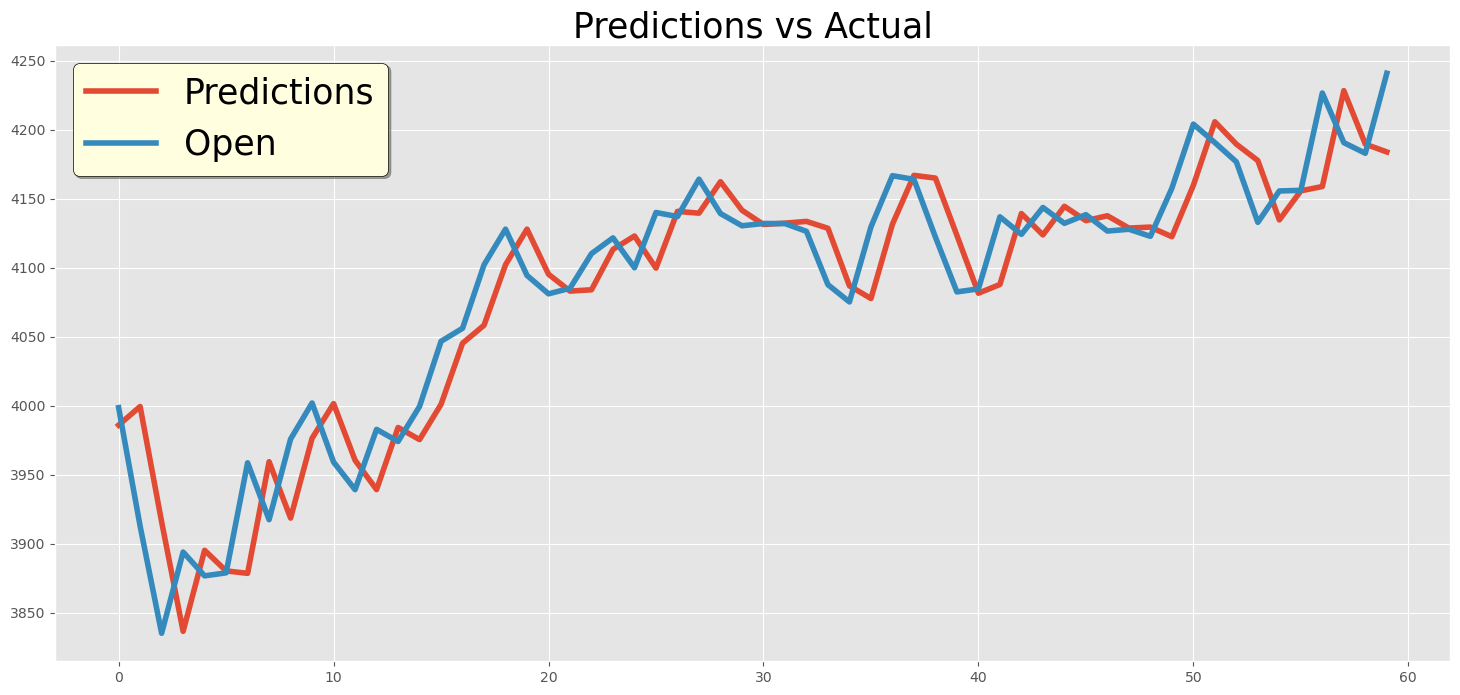

In [84]:
plt.figure(figsize=(18,8))
plt.title('Predictions vs Actual', fontsize = 25)
plt.plot(range(60), predictions, label = 'Predictions', linewidth = 4)
plt.plot(range(60), test_data, label = 'Open', linewidth = 4)
plt.legend(fontsize = 25, shadow=True,facecolor='lightyellow',edgecolor = 'k')

## Hope you like my work 😊